### Exploratory Notebook Trying to Get MHD Blast looking nice... 

So far i try...

1) Simple HLL-flux
2) HLLD flux
3) HLLD + GLM
4) HLLD + CT
5) HLLD + PPCT

The last one is closest to working, but does cost some interative loop per-time-step, but so does CTU which is what athena does?

In [2]:

import os
import sys
sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [3]:
def side_by_side(mine,athenas,title):
    fig,ax = plt.subplots(1,2,figsize=(7,4),sharey=True)
    vmin,vmax = athenas.min(),athenas.max()
    ax[0].imshow(mine,vmin=vmin,vmax=vmax)
    ax[1].imshow(athenas,vmin=vmin,vmax=vmax)
    plt.show()

In [4]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "/gpfs02/work/bhorowitz/sims/blast_mhd/"

ic_filename = "Blast_MHD.out1.00000.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)


In [4]:
#some strange index conventions, need to double check these... the axis gets a bit messed up but i think i plot them in the right order...
import jax.numpy as jnp
sol = jnp.zeros((8,64,64,64))

sol = sol.at[0].set(ICs["rho"])
sol = sol.at[1].set(ICs["vel2"])
sol = sol.at[2].set(ICs["vel1"])
sol = sol.at[3].set(ICs["vel3"])

sol = sol.at[4].set(ICs["Bcc2"])
sol = sol.at[5].set(ICs["Bcc1"])
sol = sol.at[6].set(ICs["Bcc3"])

sol = sol.at[7].set(ICs["press"])

2025-10-26 08:19:18.220248: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
import diffhydro as dh


In [6]:
eq = dh.equationmanager_mhd.EquationManagerMHD()
#eq = dh.equationmanager.EquationManager()

In [7]:
from diffhydro.solver.riemann_solver import RiemannSolver

In [8]:
ic = eq.get_conservatives_from_primitives(sol)

In [9]:
#start with basic HLL

ss = None #this isn't used in MHD 

solver = dh.HLL_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
hydro = dh.hydro(n_super_step=90, fluxes=[cf],use_mol=True, integrator="SSPRK3")

using CTU? False


In [10]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


In [11]:
field_out = output[0]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


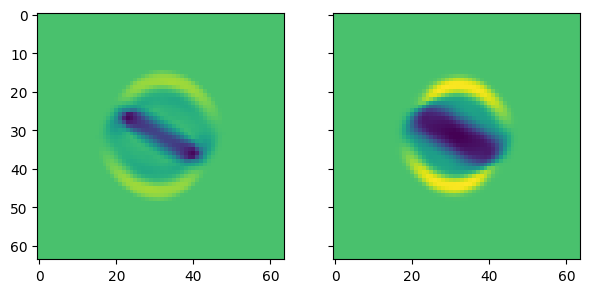

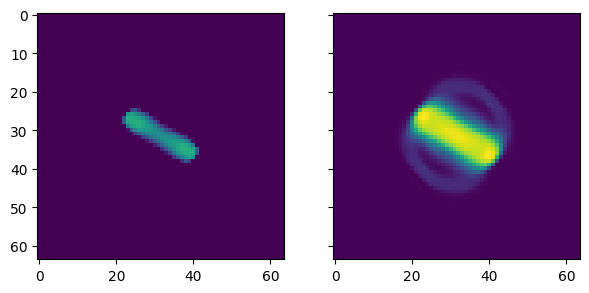

In [12]:
%pylab inline

#reference image...
fc_filename = "Blast_MHD.out1.00002.athdf"

FCs = athdf(athena_outputs_loc+fc_filename)
field_out_prim = eq.get_primitives_from_conservatives(field_out)

side_by_side(field_out_prim[5][:,:,32],FCs["Bcc1"][32],None)

side_by_side(field_out_prim[-1][:,:,32],FCs["press"][32],None)


In [13]:
#HLL_MHD is diffusive! Not surprising... lets use HLLD!

In [14]:
#ss = dh.signal_speed_Rusanov #i d
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
hydro = dh.hydro(n_super_step=90, fluxes=[cf], use_mol=True, integrator="SSPRK3",maxjit=True)

using CTU? False


In [15]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, 10000000000.0]
using CTU? False


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


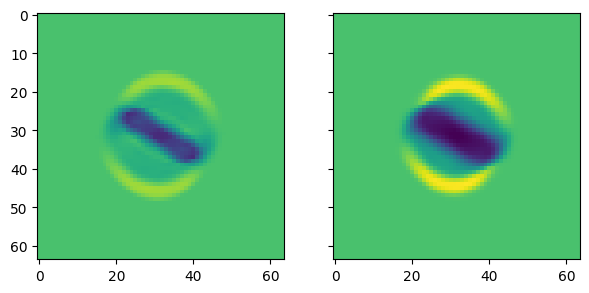

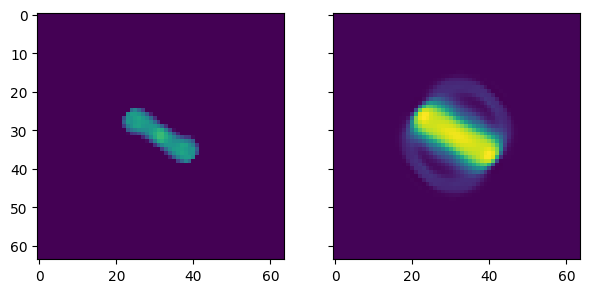

In [16]:
%pylab inline
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)

side_by_side(field_out_prim[5][:,:,32],FCs["Bcc1"][32],None)

side_by_side(field_out_prim[-1][:,:,32],FCs["press"][32],None)


In [17]:
#not that much better, need MHD expert! Probably need to use GLM... sigh...

In [18]:
#GLM time
import jax.numpy as jnp
sol = jnp.zeros((9,64,64,64))

sol = sol.at[0].set(ICs["rho"])
sol = sol.at[1].set(ICs["vel2"])
sol = sol.at[2].set(ICs["vel1"])
sol = sol.at[3].set(ICs["vel3"])

sol = sol.at[4].set(ICs["Bcc2"])
sol = sol.at[5].set(ICs["Bcc1"])
sol = sol.at[6].set(ICs["Bcc3"])

sol = sol.at[7].set(ICs["press"])

In [19]:
#not really sure how to set GLM up in terms of choosing c_h and tau...
eq = dh.equationmanager_mhd.EquationManagerMHD(use_glm=True)

In [20]:
glm = dh.mhd.GLMForcing(eq,1) #not really sure how to configure this...

In [21]:
ss = dh.signal_speed_Rusanov
#solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
hydro = dh.hydro(n_super_step=90, fluxes=[cf], forces=[glm],use_mol=True, integrator="SSPRK3")

using CTU? False


In [22]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 1000000000.0]
using CTU? False


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


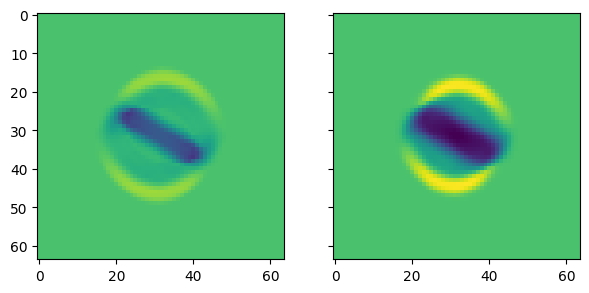

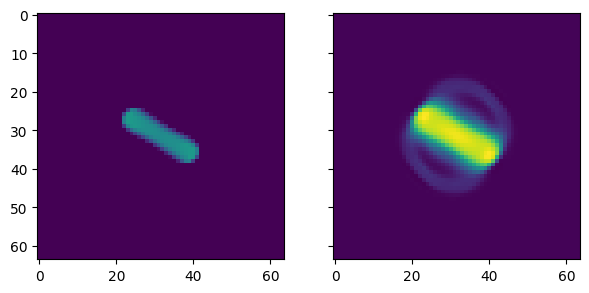

In [23]:
%pylab inline
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)

side_by_side(field_out_prim[5][:,:,32],FCs["Bcc1"][32],None)

side_by_side(field_out_prim[-2][:,:,32],FCs["press"][32],None)


In [24]:
##not really sure what I should find here... looks worse with the config i choose...

In [25]:
## CT correction idea...

In [26]:
#CT time
import jax.numpy as jnp
sol = jnp.zeros((8,64,64,64))

sol = sol.at[0].set(ICs["rho"])
sol = sol.at[1].set(ICs["vel2"])
sol = sol.at[2].set(ICs["vel1"])
sol = sol.at[3].set(ICs["vel3"])

sol = sol.at[4].set(ICs["Bcc2"])
sol = sol.at[5].set(ICs["Bcc1"])
sol = sol.at[6].set(ICs["Bcc3"])

sol = sol.at[7].set(ICs["press"])

In [27]:
eq = dh.equationmanager_mhd.EquationManagerMHD()      # 8-var MHD state
solver = dh.HLL_MHD(equation_manager=eq, signal_speed=dh.signal_speed_Rusanov)

cf = dh.ConvectiveFlux(eq, solver, dh.MUSCL3(limiter="SUPERBEE"), positivity=False)
ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="SUPERBEE"), positivity=False)

hydro = dh.hydro(
    n_super_step=160,
    fluxes=[cf, ct],        
    use_mol=True,
    integrator="SSPRK3",
)
# CT comes after CF so it can compute a correction, very elegant but does waste some amount of memory during CF that 
# gets overwritten later, but maybe doesn't matter with JIT tracing?


using CTU? False


In [28]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


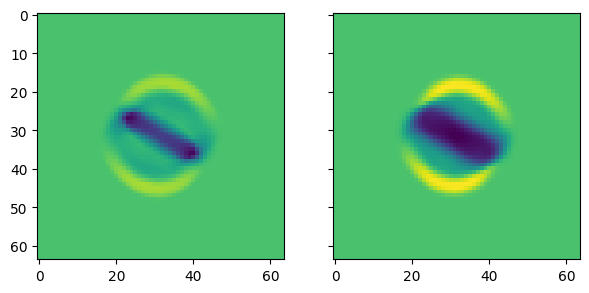

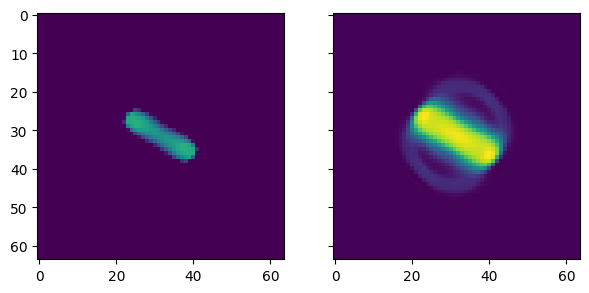

In [29]:
%pylab inline
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)

side_by_side(field_out_prim[5][:,:,32],FCs["Bcc1"][32],None)

side_by_side(field_out_prim[-1][:,:,32],FCs["press"][32],None)


In [30]:
#maybe a bit better? not really though..

In [31]:
#PPCT

In [32]:
eq = dh.equationmanager_mhd.EquationManagerMHD()
solver = dh.HLLD_MHD(equation_manager=eq, signal_speed=None)
cf = dh.ConvectiveFlux(eq, solver, dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
ppct = dh.mhd.PPCTForce(eq, boundary=dh.NoBoundary,n_iter_max=1000)  # pass a boundary, it might work... untested

hydro = dh.hydro(
    n_super_step=75,
    fluxes=[cf],
 #   forces=[ppct],           # PPCT half-steps wrap the hydro update automatically
    use_mol=True,
    integrator="SSPRK3"
)
output_noppct = hydro.evolve(sol,params)

using CTU? False
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


In [33]:

hydo = dh.hydro(
    n_super_step=125,
    fluxes=[cf,ct],
    forces=[ppct],           # PPCT half-steps wrap the hydro update automatically
    use_mol=True,
    integrator="SSPRK3"
)
output_ppct = hydo.evolve(sol,params)

using CTU? False
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


In [34]:
fields_noppct = output_noppct[0]
fields_ppct = output_ppct[0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
PPCT


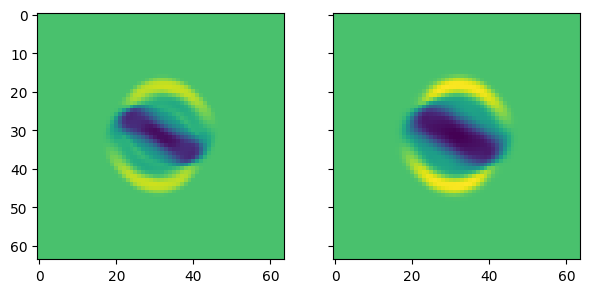

No PPCT


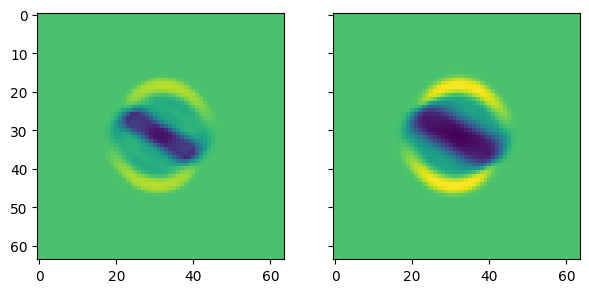

PPCT


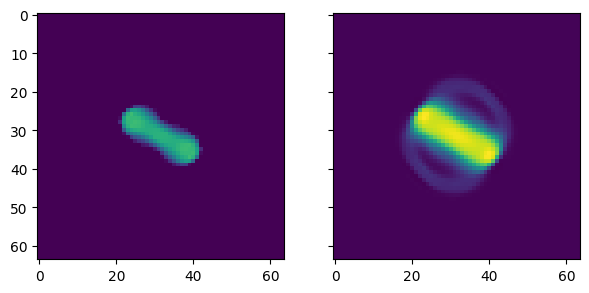

No PPCT


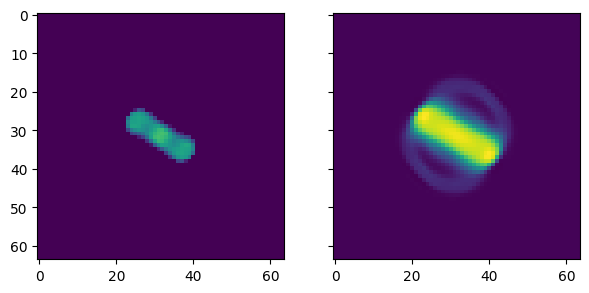

In [35]:
%pylab inline
field_out = output_ppct[0]
field_out_ppct = eq.get_primitives_from_conservatives(field_out)

field_out = output_noppct[0]
field_out_noppct = eq.get_primitives_from_conservatives(field_out)

print("PPCT")
side_by_side(field_out_ppct[5][:,:,32],FCs["Bcc1"][32],None)
print("No PPCT")

side_by_side(field_out_noppct[5][:,:,32],FCs["Bcc1"][32],None)
print("PPCT")

side_by_side(field_out_ppct[-1][:,:,32],FCs["press"][32],None)
print("No PPCT")

side_by_side(field_out_noppct[-1][:,:,32],FCs["press"][32],None)


In [36]:
#still no halo :'(

In [37]:
#all the things! CTU probably buggy?
hydro = dh.hydro(
    n_super_step=75,
    fluxes=[cf], #maybe double-doing CT, since built into CTU?
    forces=[],           # PPCT half-steps wrap the hydro update automatically
    use_mol=True,
    use_ctu=True,
    integrator="SSPRK3"
)

output_CTU = hydro.evolve(sol,params)

using CTU? True
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? True
CTU


ValueError: axis 3 is out of bounds for array of dimension 3

In [ ]:

field_out = output_CTU[0]
field_out_CTU = eq.get_primitives_from_conservatives(field_out)

print("CTU?")
side_by_side(field_out_CTU[5][:,:,32],FCs["Bcc1"][32],None)

print("PPCT")
side_by_side(field_out_ppct[5][:,:,32],FCs["Bcc1"][32],None)

In [ ]:
(field_out_CTU- field_out_noppct).min(),(field_out_CTU- field_out_noppct).max()